# Visualizing SpeechEmbedder SCOTUS d-vectors

In [2]:
!ls

CLscript.py  SCOTUS_SpeechEmbedder_Visualizations.ipynb  clustering.py


In [7]:
import os, json, pickle
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

np.random.seed(0)

In [8]:
fp = '../../data/SCOTUS/'


with open(fp+'info/spkrs.json') as f:
    spkrs = json.load(f)
    
case_path = fp+'dvectors/sco50d/'

total_cases = (len(os.listdir(case_path))/2)
train_cases = (total_cases//10)*9
print("# of training:", train_cases)
print("# total cases:" , total_cases)

# of training: 36.0
# total cases: 43.0


### import d-vectors 

In [9]:
trn_seq_lst = []
trn_cluster_lst = []
test_seq_lst = []
test_cluster_lst = []

verbose = True

if verbose:
    print("\n", "="*50, "\n Processing SVE d-vec")
        
#load 5 case-embedded dvecs (with directory holding raw files)
for i, case in enumerate(os.listdir(case_path)):
    if case[-7:] == 'seq.npy':
        case_id = case.split('/')[-1].split('_')[0]

        train_sequence = np.load(case_path+case)
        train_clus = np.load(case_path+case_id+'_id.npy')

        if verbose:
            if i > train_cases:
                print("-- Stored as test case --")
            else:
                print("-- Stored as train case --")
            print('Processed case:', case_id)
            print('emb shape:', np.shape(train_sequence))
            print('label shape:', np.shape(train_clus))    

        #add to training or testing list (for multiple cases       
        if i <= train_cases:
            trn_seq_lst.append(train_sequence)
            trn_cluster_lst.append(train_clus)
        else:
            test_seq_lst.append(train_sequence)
            test_cluster_lst.append(train_clus) 
            
            
# Only Judge Embeddings
# Training & Test set Generation
judge_seq = []
judge_id = []
test_seq = []
test_id = []
for i, case in enumerate(trn_cluster_lst):
    case_seq = []
    case_id = []
    for j, emb in enumerate(case):
        if emb<20:
            case_seq.append(trn_seq_lst[i][j])
            case_id.append(emb)
    judge_seq.append(case_seq)
    judge_id.append(case_id)
            
        
for i, case in enumerate(test_cluster_lst):
    case_seq = []
    case_id = []
    for j, emb in enumerate(case):
        if emb<20:
            case_seq.append(test_seq_lst[i][j])
            case_id.append(emb)
    test_seq.append(case_seq)
    test_id.append(case_id)



### Train K-Means

In [10]:
limit = 36
X = np.concatenate([case for case in judge_seq[:limit]])
Y = np.concatenate([id for id in judge_id[:limit]])
num = len(np.unique(Y))
print('Number of speakers in training set:', num)

Number of speakers in training set: 8


In [11]:
model = KMeans(n_clusters=num, random_state=0)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

# Single Case d-vector Heatmap

In [12]:
#create heatmap of embeddings over time
dvec = np.load(case_path+'17-1268_seq.npy')
dvec.shape

(8123, 256)

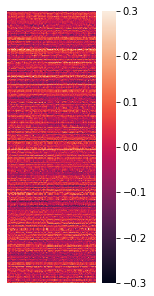

In [13]:
plt.figure(figsize=(2,5))
ax = sns.heatmap(dvec.T, vmin=-.3, vmax=.3, xticklabels = False, yticklabels = False)

# T-SNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 66864 samples in 3.963s...


In [ ]:
tsne_df_scale = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
plt.figure(figsize = (10,10))
plt.scatter(tsne_df_scale.iloc[:,0],tsne_df_scale.iloc[:,1],alpha=0.25, facecolor='lightslategray')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
kmeans_tsne_scale = KMeans(n_clusters=7, random_state=0).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale.labels_, metric='euclidean')))
# labels_tsne_scale = kmeans_tsne_scale.labels_
labels_tsne_scale = Y
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

In [ ]:
centers = kmeans_tsne_scale.cluster_centers_

plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=y_scotus, palette='tab10', s=100, alpha=0.6).set_title('Case 17-1268 - TIMIT embeddings \nCentroid projections for K-means \n trained on Judge Embeddings', fontsize=15)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='+')
plt.legend()
plt.show()